In [19]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler,AutoencoderKL
import torch
from pytorch_lightning import seed_everything
from PIL import Image
from controlnet_aux import ZoeDetector
from ip_adapter import IPAdapter


In [15]:
base_model_path = "darkstorm2150/Protogen_x3.4_Official_Release"
vae_model_path = "stabilityai/sd-vae-ft-mse"
controlnet_path = "lllyasviel/control_v11f1p_sd15_depth"
depth_path = 'lllyasviel/Annotators'
smart_ckpt = "./depth.ckpt"
# negative_prompt_path = '/home/liuxiaoyu/compare/controlnet/realisticvision-negative-embedding'

image_encoder_path = "models/image_encoder/"
ip_ckpt = "models/ip-adapter_sd15.bin"

device = "cuda"

load pretrain model

In [16]:
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)


vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet,vae=vae, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

text_encoder/model.safetensors not found
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


extract depth

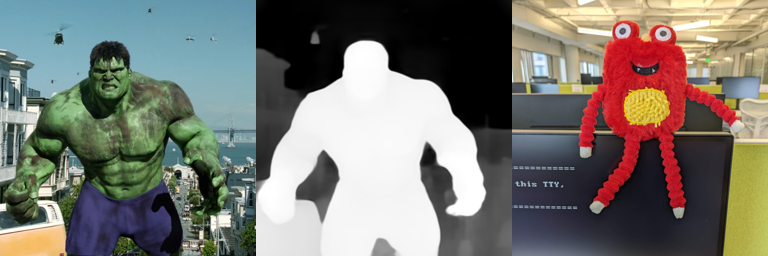

In [17]:

preprocessor = ZoeDetector.from_pretrained(depth_path)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


image = Image.open("assets/images/hulk.png")
depth_map = preprocessor(image)
ip_image = Image.open("assets/images/monster_toy.jpg")
depth_map = depth_map.resize((512,512))
ip_image = ip_image.resize((512,512))

image_grid([image.resize((256, 256)), depth_map.resize((256, 256)), ip_image.resize((256, 256))], 1, 3)



Forward

In [20]:

prompt = 'a monster toy in the street'

from smartcontrol import register_unet
from lib import init_store_attn_map

pipe = init_store_attn_map(pipe)
pipe = register_unet(pipe,smart_ckpt)
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

seed_everything(12345)
import numpy as np
print(np.array(ip_image).shape)
output = ip_model.generate(pil_image=ip_image, image=depth_map, num_samples=1, num_inference_steps=50)[0]
image_grid([ depth_map.resize((256, 256)), output.resize((256, 256))], 1, 2)


It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, controlnet, scheduler, safety_checker, feature_extractor, image_encoder to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.
Global seed set to 12345


(512, 512, 3)


  0%|          | 0/50 [00:00<?, ?it/s]


TypeError: IPAttnProcessor2_0.__call__() got an unexpected keyword argument 'timestep'